In [1]:
from time import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gpr_tfp
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

W0706 22:10:59.609389 140385029662528 logger.py:200] AstropyDeprecationWarning: astropy.extern.six will be removed in 4.0, use the six module directly if it is still needed


In [4]:
if self.tensor:
    a = tf.cos(phi)**2 / (2 * sigma_x**2) + tf.sin(phi)**2 / (2 * sigma_y**2)
    b = - tf.sin(2 * phi) / (4 * sigma_x**2) + tf.sin(2 * phi) / (4 * sigma_y**2)
    c = tf.sin(phi)**2 / (2 * sigma_x**2) + tf.cos(phi)**2 / (2 * sigma_y**2)

    uu = a * (uu1 - uu2)**2
    vv = c * (vv1 - vv2)**2
    uv = 2 * b * (uu1 - uu2)*(vv1 - vv2)

    K = var_s * tf.exp(-(uu + vv + uv))

    return K

if self.tensor:
    self.L = tf.linalg.cholesky(self.K + self.W)
    self.alpha = tf.linalg.solve(tf.transpose(self.L), tf.linalg.solve(self.L, self.Ytrain))
    self.fbar_s = tf.tensordot(tf.transpose(self.Ks), self.alpha, axes=1)

    self.v = tf.linalg.solve(self.L, self.Ks)
    self.V_s = self.Kss - tf.tensordot(tf.transpose(self.v), self.v, axes=1)
    self.sigma = tf.math.sqrt(tf.math.abs(tf.linalg.tensor_diag(self.V_s)))
    return

if self.tensor:
    LML_a = (-1/2) * tf.tensordot(self.Ytrain.T, self.alpha, axes=1)
    LML_b =  - tf.math.reduce_sum(tf.math.log(tf.linalg.tensor_diag(self.L)))
    LML_c =  - (self.nTest / 2) * np.log(2 * np.pi)
    LML = tf.math.reduce_sum(tf.linalg.diag(LML_a + LML_b + LML_c))
    return LML

SyntaxError: 'return' outside function (<ipython-input-4-ba4a6b7de526>, line 12)

In [5]:
sample = np.array([-0.3, 0, 0, 0.3])
# sample = None
GP = gpr_tfp.GPR_TFP(
    '/media/data/austinfortino/austinFull.fits',
    500,
    sample=sample,
    verbose=True,
    eps=0,
    test_size=0.2,
    random_state=0)

NameError: name 'np' is not defined

In [3]:
GP.fit()

W0706 20:46:48.775284 140546770229056 deprecation_wrapper.py:119] From /home/austinfortino/DESworkspace/gpr_tfp.py:97: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



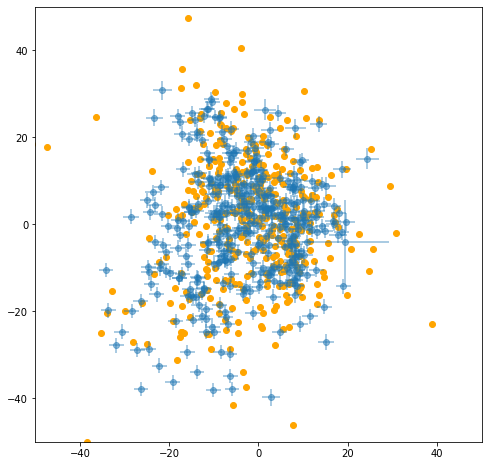

In [13]:
plt.figure(figsize=(8, 8))
plt.xlim((-50, 50))
plt.ylim((-50, 50))
plt.errorbar(GP.dx, GP.dy, xerr=GP.sigma_dx, yerr=GP.sigma_dy, fmt='o', alpha=0.5)
plt.scatter(GP.Ytest[:, 0], GP.Ytest[:, 1], color='orange')

In [15]:
GP.check_error()

Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.18274111675126903; dy: 0.23857868020304568


In [34]:
sample = np.array([-0.3, 0, 0, 0.3])
# sample = None
GP = gpr_tfp.GPR_TFP(
    '/media/data/austinfortino/austinFull.fits',
    500,
    sample=sample,
    verbose=True,
    eps=0,
    test_size=0.2,
    random_state=0)

Extracting exposure from fits file...
Filename: /media/data/austinfortino/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   

Extracting exposure data...
Splitting data into training and testing sets...
Generating white noise covariance function...


In [35]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
observation_noise_variance = tf.exp(tf.Variable(np.float64(GP.Etrain.mean())), name='observation_noise_variance')

In [36]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=GP.Xtrain,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(GP.Ytrain[:, 1])

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

gprm_u = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=GP.Xtest,
    observation_index_points=GP.Xtrain,
    observations=GP.Ytrain[:, 0],
    observation_noise_variance=observation_noise_variance)

mean = gprm_u.mean()
sigma = gprm_v.stddev()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(500):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    dx = sess.run(mean)
    sdx = sess.run(sigma)

Step 0: NLL = 5156.754056912843
Step 100: NLL = 1566.1320553127277
Step 200: NLL = 1554.0095570801327
Step 300: NLL = 1552.7238012560638
Step 400: NLL = 1552.6870839518135
Final NLL = 1552.6870087705465


In [37]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=GP.Xtrain,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(GP.Ytrain[:, 1])

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

gprm_v = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=GP.Xtest,
    observation_index_points=GP.Xtrain,
    observations=GP.Ytrain[:, 1],
    observation_noise_variance=observation_noise_variance)

mean = gprm_v.mean()
sigma = gprm_v.stddev()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(500):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    dy = sess.run(mean)
    sdy = sess.run(sigma)

Step 0: NLL = 5156.754056912843
Step 100: NLL = 1566.1320553127277
Step 200: NLL = 1554.0095570801327
Step 300: NLL = 1552.7238012560638
Step 400: NLL = 1552.6870839518135
Final NLL = 1552.6870087705465


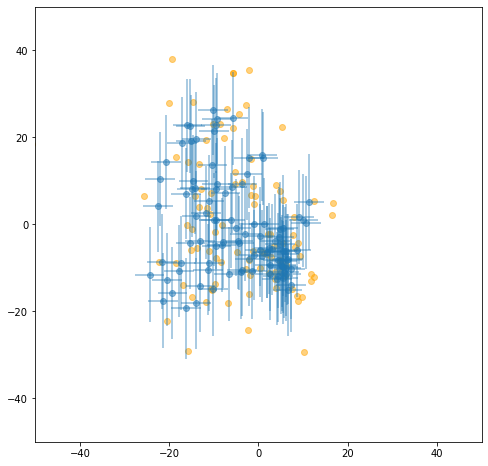

In [39]:
plt.figure(figsize=(8, 8))
plt.xlim((-50, 50))
plt.ylim((-50, 50))
plt.errorbar(dx, dy, xerr=sdx, yerr=sdy, fmt='o', alpha=0.5)
plt.scatter(GP.Ytest[:, 0], GP.Ytest[:, 1], color='orange', alpha=0.5)